# Synthetic Dataset Generation for NLP and Robotic Kinematics

This notebook generates a synthetic dataset optimized for combined NLP and robotic kinematics tasks in a reinforcement learning model. The dataset includes both textual and sensor data, with feature engineering applied to enhance its suitability for machine learning tasks.

## NLP Data Generation Using Brown Corpus

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Download necessary NLTK packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('brown')

# Define a list of possible commands for NLP data generation
commands = ["move forward", "move backward", "turn left", "turn right",
            "accelerate", "decelerate", "stop", "pick up", "drop", "scan area"]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


## Synthetic Dataset Generation Function

In [2]:
# Function to simulate realistic command embeddings
def simulate_command_embeddings(command_list, embedding_dim=16):
    command_embeddings = {cmd: np.random.rand(embedding_dim) for cmd in command_list}
    return command_embeddings

# Define a more sophisticated reward function
def calculate_reward(command, sensor_states, action):
    # Insert reward calculation logic based on the command, sensor_states, and action
    reward = 0
    if command == "move forward" and action == 0:
        reward = sensor_states[-1]  # Reward positively correlated with last sensor state
    elif command == "turn right" and action == 3:
        reward = np.mean(sensor_states)  # Reward based on average sensor state
    elif command == "stop" and action == 6:
        reward = 1 - np.std(sensor_states)  # Reward for stability
    else:
        reward = -1 * np.std(sensor_states)  # Penalize high variance in sensor readings
    return reward

# Generate synthetic dataset with realistic sequences and command embeddings
def generate_synthetic_dataset(num_samples=1000, sequence_length=128, num_features=512, num_actions=10, noise_level=0.05, embedding_dim=16, nlp_features_dim=512):
    # Generate timestamps
    timestamps = [datetime.now() + timedelta(seconds=i) for i in range(num_samples)]

    # Initialize the data dictionary with commands and embeddings
    data = {'timestamp': [timestamp.strftime('%Y-%m-%d %H:%M:%S') for timestamp in timestamps]}
    random_commands = [random.choice(commands) for _ in range(num_samples)]
    data['command'] = random_commands
    command_embeddings = simulate_command_embeddings(commands, embedding_dim)
    for i in range(embedding_dim):
        data[f'command_embedding_{i}'] = [command_embeddings[cmd][i] for cmd in random_commands]

    # Simulate sensor data with trends and noise
    sensor_data = np.zeros((num_samples, sequence_length * num_features))
    for timestep in range(sequence_length):
        for feature in range(num_features):
            period = np.random.randint(10, 100)
            drift = np.random.randn() * 0.01
            bias = np.random.randn() * 0.01
            sensor_signal = np.sin(np.linspace(0, 2 * np.pi * period, num_samples)) + drift + bias
            noise = np.random.normal(0, noise_level, num_samples)
            sensor_data[:, timestep * num_features + feature] = sensor_signal + noise

    # Simulate actions and rewards
    actions = np.random.randint(0, num_actions, num_samples)
    data['action'] = actions
    data['reward'] = [calculate_reward(random_commands[i], sensor_data[i, :], actions[i]) for i in range(num_samples)]

    # One-hot encode actions
    for i in range(num_actions):
        data[f'action_{i}'] = (actions == i).astype(int)

    # Load Brown Corpus and prepare NLP features
    brown_words = nltk.corpus.brown.words()
    brown_text = [' '.join(brown_words)]
    vectorizer = TfidfVectorizer(max_features=nlp_features_dim, stop_words='english')
    vectorizer.fit(brown_text)  # Fit the vectorizer to the Brown Corpus

    # Generate NLP features for each sample command
    nlp_features = vectorizer.transform(random_commands).toarray()
    for i in range(nlp_features_dim):
        data[f'nlp_feature_{i}'] = nlp_features[:, i]

    # Combine all data into a DataFrame
    sensor_columns = [f'sensor_{i}' for i in range(sequence_length * num_features)]
    action_columns = [f'action_{i}' for i in range(num_actions)]
    nlp_columns = [f'nlp_feature_{i}' for i in range(nlp_features_dim)]
    all_columns = ['timestamp', 'command'] + sensor_columns + action_columns + ['reward'] + nlp_columns
    complete_data = {col: data[col] for col in all_columns if col in data}

    return pd.DataFrame(complete_data)

# Define dataset parameters to match model input shape
num_samples = 1000  # Number of samples to generate
sequence_length = 128  # Number of timesteps per sample
num_features = 512  # Number of features per timestep
num_actions = 10  # Number of possible actions
noise_level = 0.05  # Noise level for sensor data
embedding_dim = 16  # Dimension of command embeddings
nlp_features_dim = 512  # Number of NLP features to generate

# Generate the dataset with additional NLP features
synthetic_dataset = generate_synthetic_dataset(num_samples, sequence_length, num_features, num_actions, noise_level, embedding_dim, nlp_features_dim)

# Save the dataset to a CSV file
file_path = 'Sephs_dataset.csv'
synthetic_dataset.to_csv(file_path, index=False)

# Print the first 3 rows of the dataset
print(synthetic_dataset.head(3))

print(f'Dataset saved at {file_path}')

             timestamp     command  action_0  action_1  action_2  action_3  \
0  2024-02-12 00:47:31   scan area         0         0         0         0   
1  2024-02-12 00:47:32        stop         0         0         0         0   
2  2024-02-12 00:47:33  decelerate         0         0         0         1   

   action_4  action_5  action_6  action_7  ...  nlp_feature_502  \
0         1         0         0         0  ...              0.0   
1         0         0         0         0  ...              0.0   
2         0         0         0         0  ...              0.0   

   nlp_feature_503  nlp_feature_504  nlp_feature_505  nlp_feature_506  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   

   nlp_feature_507  nlp_feature_508  nlp_feature_509  nlp_feature_510  \
0              0.0              0.0              0.0

In [3]:
df = pd.read_csv('Sephs_dataset.csv')
df.head(3)

,timestamp,command,action_0,action_1,action_2,action_3,action_4,action_5,action_6,action_7,...,nlp_feature_502,nlp_feature_503,nlp_feature_504,nlp_feature_505,nlp_feature_506,nlp_feature_507,nlp_feature_508,nlp_feature_509,nlp_feature_510,nlp_feature_511
0,2024-02-12 00:47:31,scan area,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2024-02-12 00:47:32,stop,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2024-02-12 00:47:33,decelerate,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# The step Below the model schematic should provide a Shape suitable for the model input.
*(127, 512)*

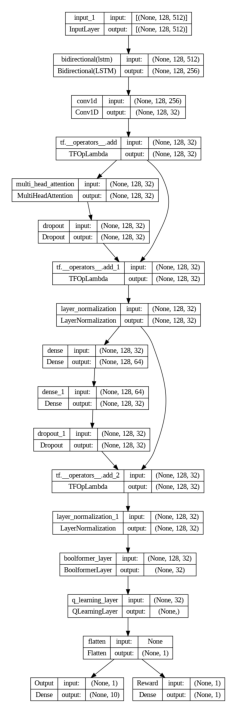

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the PNG image
img = mpimg.imread('model_architecture.png')

# Set the figure size (adjust the width and height as needed)
plt.figure(figsize=(12, 9))

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

# The model expects 3 dimensional input.
*(num_samples, sequence_length, 512)*
127 time step sequences and 512 features

In [5]:
df.shape

(1000, 525)

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load the dataset
data = pd.read_csv('/content/Sephs_dataset.csv')

# Ensure there are sensor columns in the dataset
sensor_columns = [col for col in data.columns if 'sensor' in col]
if not sensor_columns:
    raise ValueError("No sensor columns found in the dataset.")

# Set the number of sensor columns to visualize
num_sensors_to_plot = min(5, len(sensor_columns))  # Adjust to plot up to 5 sensors
sensor_data = data[sensor_columns[:num_sensors_to_plot]]

# Set a consistent color palette
palette = sns.color_palette("husl", num_sensors_to_plot)

# Determine the size of the grid needed for subplots
num_rows = (num_sensors_to_plot + 1) // 2 + 2  # Additional rows for boxplot and heatmap
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(20, 5 * num_rows))

# Create histograms for each sensor
for i, sensor in enumerate(sensor_data.columns):
    ax = axes[i // 2, i % 2]  # Determine the position of the subplot
    sns.histplot(sensor_data[sensor], kde=True, color=palette[i], ax=ax)
    ax.set_title(f'Distribution for {sensor}', fontsize=15)
    ax.set_xlabel('Sensor Value', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(True)

# Boxplot for sensor data (in the next available row)
boxplot_row = num_sensors_to_plot // 2 if num_sensors_to_plot % 2 == 0 else num_sensors_to_plot // 2 + 1
sns.boxplot(data=sensor_data, palette=palette, ax=axes[boxplot_row, 0])
axes[boxplot_row, 0].set_title('Boxplot for Sensor Data', fontsize=15)
axes[boxplot_row, 0].tick_params(axis='x', rotation=45)
axes[boxplot_row, 0].set_xlabel('Sensor', fontsize=12)
axes[boxplot_row, 0].set_ylabel('Value', fontsize=12)
axes[boxplot_row, 0].grid(True)

# Correlation Heatmap for sensor data (next to the boxplot)
sns.heatmap(sensor_data.corr(), annot=True, cmap='coolwarm', ax=axes[boxplot_row, 1])
axes[boxplot_row, 1].set_title('Correlation Heatmap for Sensor Data', fontsize=15)

# Visualization for NLP Data (if present)
if 'text_data' in data.columns:
    text_data = data['text_data'].dropna()  # Drop NaN values if any
    # Generate a word cloud if there is text data
    if not text_data.empty:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text_data))
        axes[num_rows - 1, 0].imshow(wordcloud, interpolation='bilinear')
        axes[num_rows - 1, 0].axis('off')
        axes[num_rows - 1, 0].set_title('Word Cloud for Text Data', fontsize=15)
    else:
        print("No text data available for word cloud visualization.")
else:
    print("No text data column found in the dataset.")

# Hide any unused subplots
for i in range(num_sensors_to_plot, num_rows * 2):
    fig.delaxes(axes[i // 2, i % 2])

# Adjust layout
plt.tight_layout()
plt.show()
print(data.shape)

ValueError: No sensor columns found in the dataset.